## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

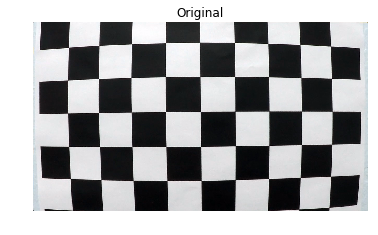

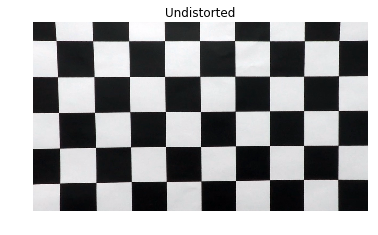

In [9]:
import numpy as np
import imageio
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1],img.shape[0]), None, None)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "./wide_dist_pickle.p", "wb" ) )
    undist = cv2.undistort(img, mtx, dist, None, mtx )
    return undist


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # plt.axis('off')
        # plt.imshow(img)
        # plt.show()
        
img = cv2.imread('../camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

plt.title('Original')
plt.axis('off')
plt.imshow(img)
imageio.imwrite('../output_images/original.jpg',img)
plt.show()

plt.title('Undistorted')
plt.axis('off')
plt.imshow(undistorted)
imageio.imwrite('../output_images/undistorted.jpg',undistorted)
plt.show()
cv2.destroyAllWindows()

## Undistort camera image using calibration matrix

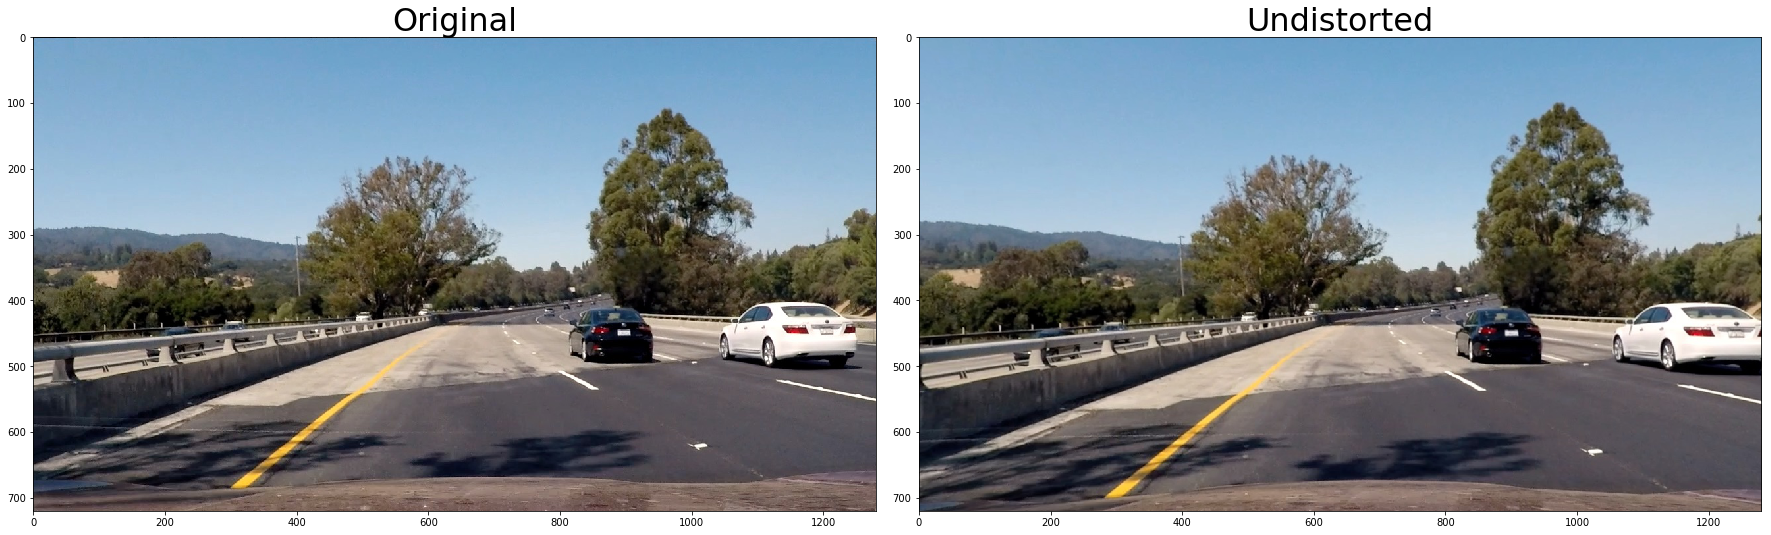

In [11]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dist_pickle = pickle.load( open( "./wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

rawImg = cv2.imread('../test_images/test4.jpg')
rawImg = cv2.cvtColor(rawImg, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(rawImg, mtx, dist, None, mtx )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rawImg)
ax1.axis('off')
ax1.set_title('Original', fontsize=32)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image.